# Fitting $R_t$ From COVID-19 Infection Data

This notebook was originally based off the `Realtime R0.ipynb` calculation, but intended to produce a Bayesian posterior over the values of $R_t$ *and* $\sigma$ given the data instead of only fitting $R_t$ using a max-likelihood estimate for $\sigma$.  It has now diverged significantly; the underlying model is fairly similar to `Realtime Rt mcmc.ipynb`, but our data handling differs in that we do not attempt to account for delays between infection, onset of symptoms, and confirmation.  Instead, we are estimating $R_t$ *of confirmation* (roughly, the delay time from infection to confirmation is one to two weeks---so our estimate will lag the infection $R_t$ by a week or two).  

We also use the [JHU](https://coronavirus.jhu.edu/map.html) dataset which you can find [here](https://github.com/CSSEGISandData/COVID-19) instead of the original data source.

We also employ a slightly different smoothing scheme (an exponential window with a decay rate of 7 days, to smooth out fluctuations on timescales shorter than (a) one week and (b) the serial timescale of the disease itself).  We use Stan to sample over the AR(1) prior for $R_t$ (increments are independent Gaussian variables) and also $\sigma$, the s.d. of the increment distribution. 

The [Stan](http://mc-stan.org) model we use for the sampling can be found in the `R0.stan` file in the current directory.

Note that our Python environment is captured in `environment.yml`; issuing
```zsh
conda env create -f environment.yml
```
should duplicate it on your system.  You can then activate it via 
```zsh
conda activate covid-19
```

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import datetime
import matplotlib.dates as md
import os
import os.path
import pandas as pd
import pystan
import seaborn as sns
from tqdm import tqdm

sns.set_context('notebook')
sns.set_palette('colorblind')

Download the latest data from JHU (note this is a different, but essentially identical, dataset to the original tracker).

In [3]:
def should_use_col(cname):
    if cname in ['Province_State', 'FPIS']:
        return True
    else:
        try:
            datetime.datetime.strptime(cname, '%m/%d/%y')
        except:
            return False
        return True
    
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
states = pd.read_csv(url,
                     index_col=['Province_State'],
                     usecols=should_use_col,
                     squeeze=True).sort_index()
states = states.groupby('Province_State').aggregate(np.sum)
states.columns = [datetime.datetime.strptime(c, '%m/%d/%y').strftime('%Y-%m-%d') for c in states.columns]

Compile the Stan model that simultaneously fits for $R_t$ and $\sigma$.  Our model differs from that in http://rt.live in several respects.  Trivially, we choose different priors on $\sigma$ (the scatter from one day to the next in the imposed prior on $R_t$), the first day's infection count, and $R_1$.  

Less trivially, http://rt.live assume that on day $i$ the expected number of positive tests is 
$$
\Lambda_i = k_{i-1} \exp\left( \frac{1 \, \mathrm{d}}{\tau} \left( R_i - 1 \right) \right),
$$
where $k_{i-1}$ is the *observed* number of positive tests in the previous day, $\tau$ is the serial time (the mean time between infectious cases), and $R_i$ is the time-dependent reproduction number at day $i$.  However, this is not quite the solution to an instantaneous SIR model; it assumes that the *actual* number of infected cases responsible infecting those on day $i$ is $k_{i-1}$, the *observed* number of cases from the day before.  Instead, an SIR solution---and the model in the Stan code below---would have 
$$
\Lambda_i = \Lambda_{i-1} \exp\left( \frac{1 \, \mathrm{d}}{\tau} \left( R_i - 1 \right) \right);
$$
that is, the expected cases in period $i$ depend on the expected cases in period $i-1$.  This change makes the fit less certain about the expected number of cases on day $i$ (since the observation, $k_{i-1}$ is assumed perfectly known, while the *expected* number of cases $\Lambda_{i-1}$ is, in turn, estimated from the previous day's data with uncertainty).  *Without stochastic sampling*, it would not be possible to fit this model, because the likelihoods on successive days are coupled to each other---so the approach in `Realtime R0.ipynb`, where each day's likelihood function is computed independently, would not be possible.  

Another major difference is that we marginalize over the serial number, using a log-normal distribution that matches a user-input mean and s.d.  See below.  This requires a somewhat strange parameterization, since otherwise $\tau$ and $R_t$ are very correlated, and we suffer from [Neal's funnel](https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html) as $\tau \to 0$; we sample in the $\Lambda_i$, and *derive* $R_t$ via 
$$
R_i = \tau \left( \log \Lambda_i - \log \Lambda_{i-1} \right) + 1
$$
(note that for small $R$ this can result in *negative* $R$).  To implement the AR(1) prior on the $R_t$, the model incorporates Jacobian factors to adjust the density for the sampling in $\Lambda_t$.

In [4]:
model = pystan.StanModel(file='R0.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_afe22f9b9947e3eb5a16d4d97720d4a1 NOW.


We marginalize over the serial time, based on the mean and standard deviation reported at https://epiforecasts.io/covid/ (which, in turn, come from [Nishiura, Linton, & Akhmetzhanov (2020)](https://doi.org/10.1101/2020.02.03.20019497)).

In [5]:
serial_mean = 4.7
serial_std = 2.9

## One State By Hand

Here we do my home state (NY) by hand, just to show aspects of the data processing, fitting, and plotting; stay tuned for the bulk run.

I chose to use an exponential filter with a 7-day time constant for smoothing instead of a Gaussian filter with a 2-day time-constant.  I think the 7-day constant is more appropriate for two reasons:
1. The amount of testing fluctuates between week and weekend (both because of supply and demand issues)
1. The serial time of the virus is ~7 days (assumed in the calculation below), so any given infected person is assumed able to infect others over 7 days.

This seems to eliminate the "oscillations" seen at http://rt.live (since it is smoothing on a longer timescale).

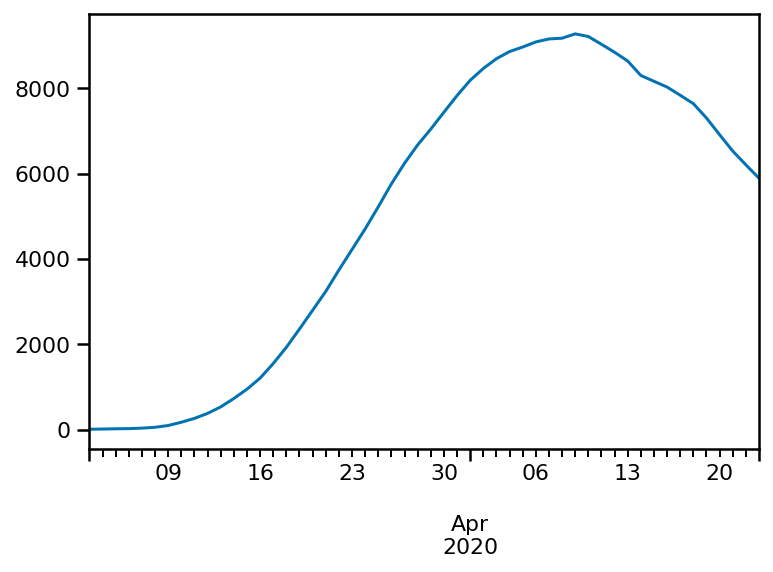

In [16]:
new_cases = states.loc['New York'].diff()
smooth_new_cases = new_cases.rolling(20,
                                     win_type='exponential',
                                     min_periods=1,
                                     center=True).mean(tau=7)
i10 = np.where(smooth_new_cases.gt(10))[0][0]
smooth_new_cases = smooth_new_cases.iloc[i10:]
smooth_new_cases.index = pd.to_datetime(smooth_new_cases.index)
smooth_new_cases.plot()

data = {
    'ndays': len(smooth_new_cases),
    'k': array(smooth_new_cases).astype(np.int),
    'tau_mean': serial_mean,
    'tau_std': serial_std
}

Run the fits, hinting to `arviz` that it should use the appropriate date-time coordinates for the expected number of counts and $R_t$.

In [17]:
fit = az.from_pystan(model.sampling(data=data), 
                     coords={'exp_cts_dates': smooth_new_cases.index,
                             'Rt_dates': smooth_new_cases.index[1:]},
                     dims={'exp_cts': ['exp_cts_dates'],
                           'Rt': ['Rt_dates']})

A quick traceplot, just because it looks pretty:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaafce1b750>,
      dtype=object)

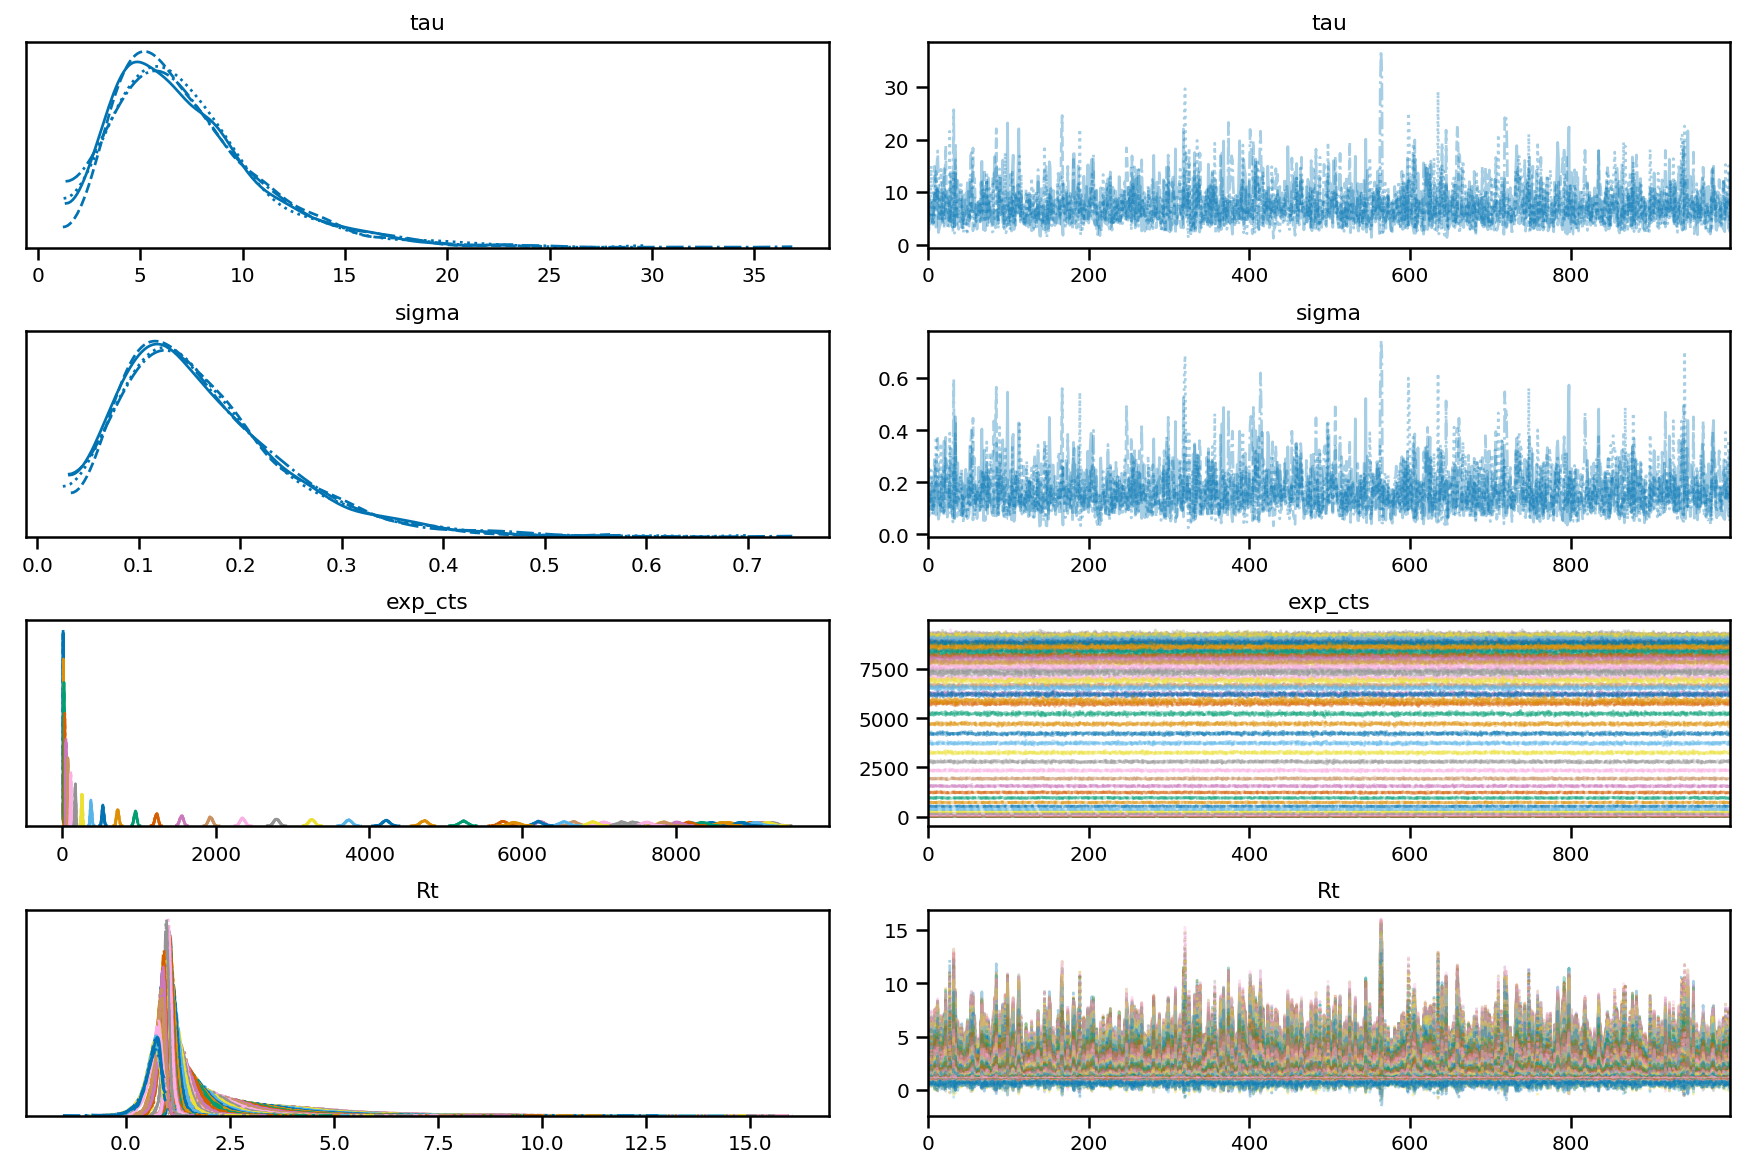

In [18]:
az.plot_trace(fit, compact=True)

In [19]:
print(az.summary(fit))
az.ess(fit).min()

              mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
tau          7.399  3.699   2.152   14.333      0.075    0.056    2428.0   
sigma        0.167  0.085   0.044    0.322      0.002    0.001    2338.0   
exp_cts[0]   8.573  1.330   5.962   10.883      0.032    0.022    1761.0   
exp_cts[1]  12.911  1.566  10.053   15.892      0.040    0.028    1546.0   
exp_cts[2]  19.496  1.852  16.152   23.030      0.051    0.036    1295.0   
...            ...    ...     ...      ...        ...      ...       ...   
Rt[46]       0.679  0.178   0.359    0.933      0.003    0.002    2640.0   
Rt[47]       0.606  0.214   0.222    0.908      0.004    0.003    2798.0   
Rt[48]       0.589  0.219   0.176    0.905      0.004    0.003    2691.0   
Rt[49]       0.610  0.212   0.212    0.902      0.004    0.003    2756.0   
Rt[50]       0.615  0.223   0.222    0.933      0.004    0.003    2637.0   

            ess_sd  ess_bulk  ess_tail  r_hat  
tau         2188.0    2632.0    2670.0 

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tau      float64 2.632e+03
    sigma    float64 2.441e+03
    exp_cts  float64 1.123e+03
    Rt       float64 2.607e+03

(737485.5, 737540.5, 0.0, 5.0)

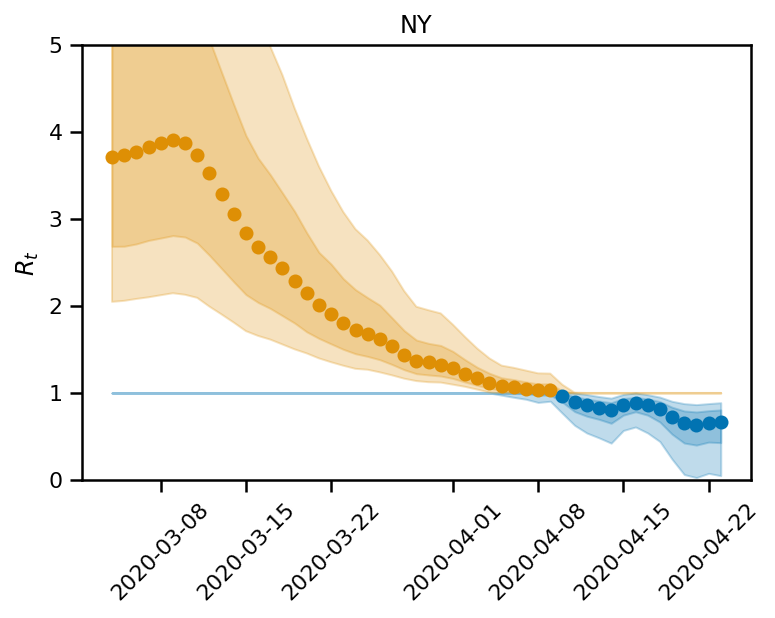

In [21]:
m = median(fit.posterior.Rt, axis=(0,1))
hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
h = percentile(fit.posterior.Rt, 84, axis=(0,1))
l = percentile(fit.posterior.Rt, 16, axis=(0,1))
ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

x = fit.posterior.Rt_dates.values

good_dates = m <= 1.0
bad_dates = m > 1.0

plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

title('NY')

xticks(rotation=45)
ylabel(r'$R_t$')

axis(ymin=0, ymax=5)

## All States

In [26]:
def fit_state(states, state_key):
    new_cases = states.loc[state_key].diff()
    smooth_new_cases = new_cases.rolling(20,
                                         win_type='exponential',
                                         min_periods=1,
                                         center=True).mean(tau=7)
    i10 = np.where(smooth_new_cases.gt(10))[0][0]
    smooth_new_cases = smooth_new_cases.iloc[i10:]
    smooth_new_cases.index = pd.to_datetime(smooth_new_cases.index)

    data = {
        'ndays': len(smooth_new_cases),
        'k': array(smooth_new_cases).astype(np.int),
        'tau_mean': serial_mean,
        'tau_std': serial_std
    }
    
    tries = 0
    iter = 2000
    thin = 1
    while tries < 3:
        fit = az.from_pystan(model.sampling(data=data, iter=iter, thin=thin), 
                             coords={'exp_cts_dates': smooth_new_cases.index,
                                     'Rt_dates': smooth_new_cases.index[1:]},
                             dims={'exp_cts': ['exp_cts_dates'],
                                   'Rt': ['Rt_dates']})
        ess = az.ess(fit, var_names=['tau', 'sigma', 'exp_cts']).min()
        if ess.tau > 1e2 and ess.sigma > 1e2 and ess.exp_cts > 1e2 and np.all(az.bfmi(fit) > 0.2):
            break
        else:
            tries += 1
            iter *= 2
            thin *= 2
    
    return fit

We run the fit on each state (takes ten-twenty minutes on my MacBook); some states have no data, so we skip those.  The fits may be marginal on some states (see warnings about [E-BFMI](https://mc-stan.org/misc/warnings.html#bfmi-low); for states with few measurements (or small numbers of infected cases), the model falls back on the prior, and the parameterization chosen is optimized for posteriors that are likelihood (i.e. measurement) dominated.  The prior produces quite a strong correlation between successive expected counts in the absence of a strong measurement, which causes the sampler to struggle.
For prior-dominated sampling, re-parameterizing in terms of the *change* in $R_t$ from day to day would be better than the expected counts, since the change in $R_t$ is independent and normally-distributed under the prior.

In [30]:
state_fits = {}
with tqdm(states.groupby(level=0)) as bar:
    for st, _ in bar.iterable:
        try:
            if np.all(np.isnan(states.loc[st]) | (states.loc[st] == 0)):
                bar.write('Skipping state: {:s}'.format(st))
                bar.update(1)
                continue
            state_fits[st] = fit_state(states, st)
            bar.update(1)
        except (RuntimeError, IndexError):
            bar.write('State {:s} failed with RuntimeError; skipping'.format(st))
            bar.update(1)
            continue

  3%|▎         | 2/58 [00:28<10:25, 11.16s/it]

Skipping state: American Samoa


 16%|█▌        | 9/58 [01:27<06:42,  8.21s/it]

State Diamond Princess failed with RuntimeError; skipping


 24%|██▍       | 14/58 [01:45<04:30,  6.15s/it]

State Grand Princess failed with RuntimeError; skipping
State Guam failed with RuntimeError; skipping


 67%|██████▋   | 39/58 [07:24<07:48, 24.67s/it]

State Northern Mariana Islands failed with RuntimeError; skipping


 90%|████████▉ | 52/58 [08:50<00:55,  9.17s/it]

State Virgin Islands failed with RuntimeError; skipping


100%|██████████| 58/58 [09:33<00:00,  9.89s/it]


Save all the fits; use `load_state_fits` (untested) to load them back in.

In [31]:
def save_state_fits(fits, directory):
    try:
        os.makedirs(directory)
    except OSError:
        pass
    
    for k, f in fits.items():
        az.to_netcdf(f, os.path.join(directory, k + '.nc'))
def load_state_fits(directory):
    fits = {}
    for f in glob.glob(os.path.join(directory, '*.nc')):
        k = os.path.splitext(os.path.split(f)[1])[0]
        fits[k] = az.from_netcdf(f)

In [32]:
save_state_fits(state_fits, 'state_fits')

And make a plot that is similar to the one at http://rt.live

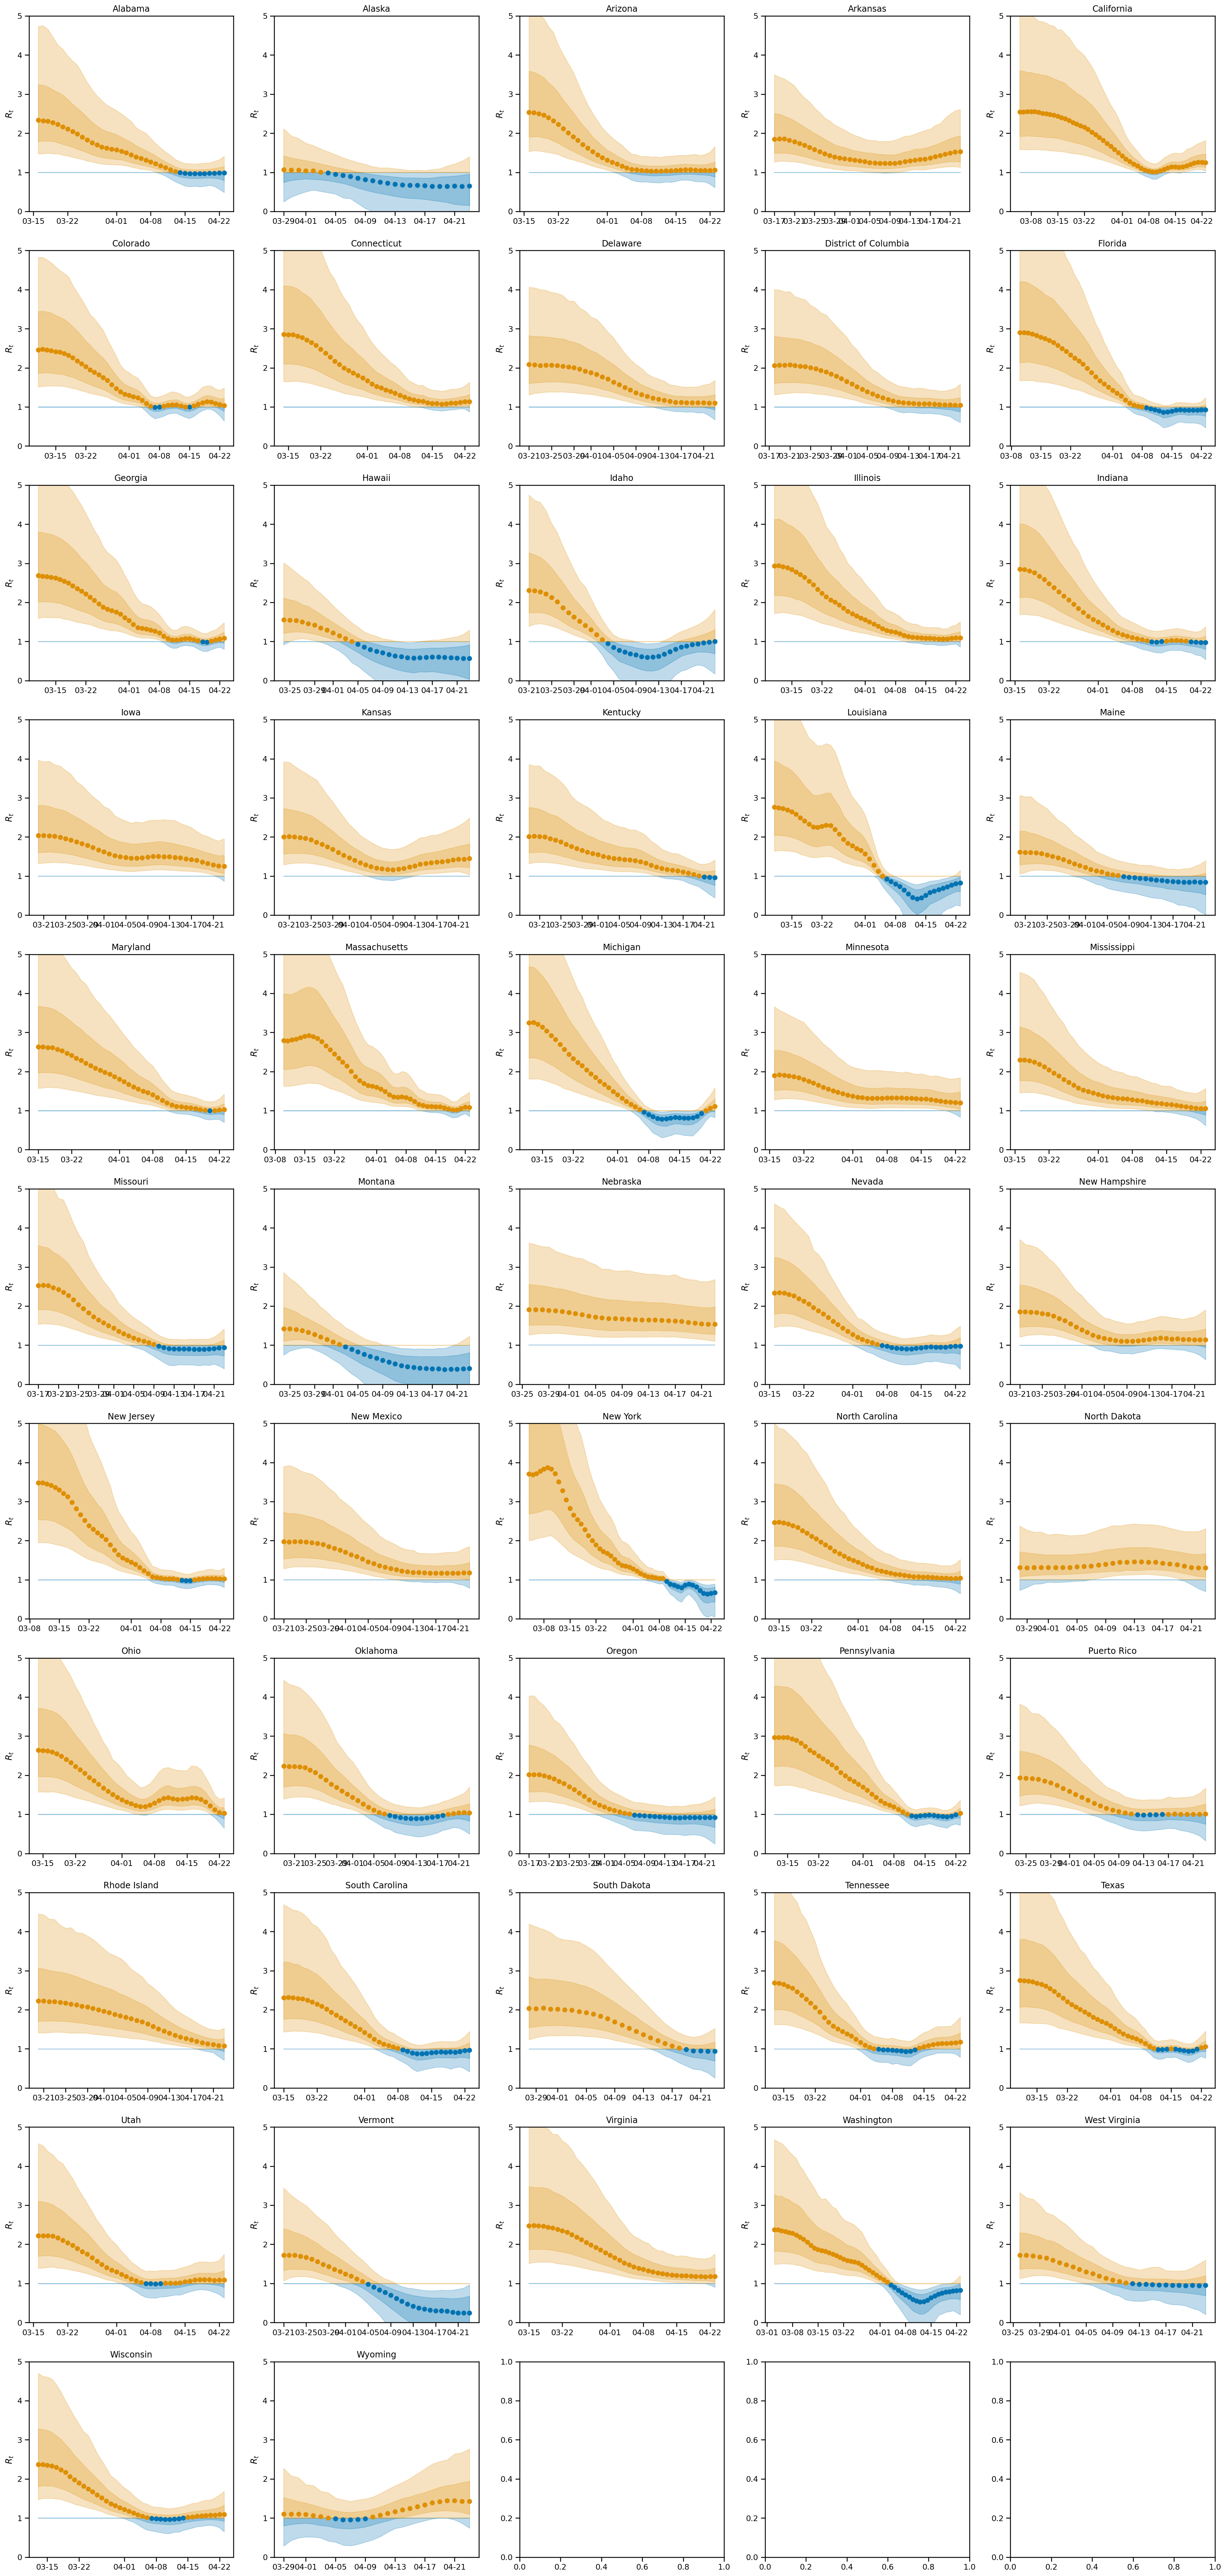

In [33]:
nc = 5
nr = 11

fig, axes = subplots(nrows=nr, ncols=nc, figsize=(30, 66))

for (k,fit), ax in zip(state_fits.items(), axes.flatten()):
    m = median(fit.posterior.Rt, axis=(0,1))
    hh = percentile(fit.posterior.Rt, 97.5, axis=(0,1))
    h = percentile(fit.posterior.Rt, 84, axis=(0,1))
    l = percentile(fit.posterior.Rt, 16, axis=(0,1))
    ll = percentile(fit.posterior.Rt, 2.5, axis=(0,1))

    x = fit.posterior.Rt_dates.values

    good_dates = m <= 1.0
    bad_dates = m > 1.0

    ax.plot_date(x[good_dates], m[good_dates], xdate=True, color=sns.color_palette()[0])
    ax.fill_between(x, where(h<1, h, 1) , where(l<1, l, 1), alpha=0.25, color=sns.color_palette()[0])
    ax.fill_between(x, where(hh<1, hh, 1) , where(ll<1, ll, 1), alpha=0.25, color=sns.color_palette()[0])

    ax.plot_date(x[bad_dates], m[bad_dates], xdate=True, color=sns.color_palette()[1])
    ax.fill_between(x, where(h>1, h, 1) , where(l>1, l, 1), alpha=0.25, color=sns.color_palette()[1])
    ax.fill_between(x, where(hh>1, hh, 1) , where(ll>1, ll, 1), alpha=0.25, color=sns.color_palette()[1])

    date_fmt = md.DateFormatter('%m-%d')
    ax.xaxis.set_major_formatter(date_fmt)
    
    ax.set_title(k)
    ax.set_ylabel(r'$R_t$')
    ax.set_ylim(0, 5)

Here is a nice plot that shows the distribution of $R_t$ at the latest day of sampling, ordered by its median value:

In [34]:
nc = 4
nd = 1000

d = {'state': [], 'Rt': []}
for k, f in state_fits.items():
    d = {'state': concatenate((d['state'], (k,)*(nc*nd))), 'Rt': concatenate((d['Rt'], f.posterior.Rt[:,:,-1].values.flatten()))}
df = pd.DataFrame(d)

sort_Rts = [percentile(fit.posterior.Rt[:,:,-1], 75) for fit in state_fits.values()]
state_order = array(list(state_fits.keys()))[argsort(sort_Rts)]

Compare to http://rt.live:

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51]),
 <a list of 52 Text major ticklabel objects>)

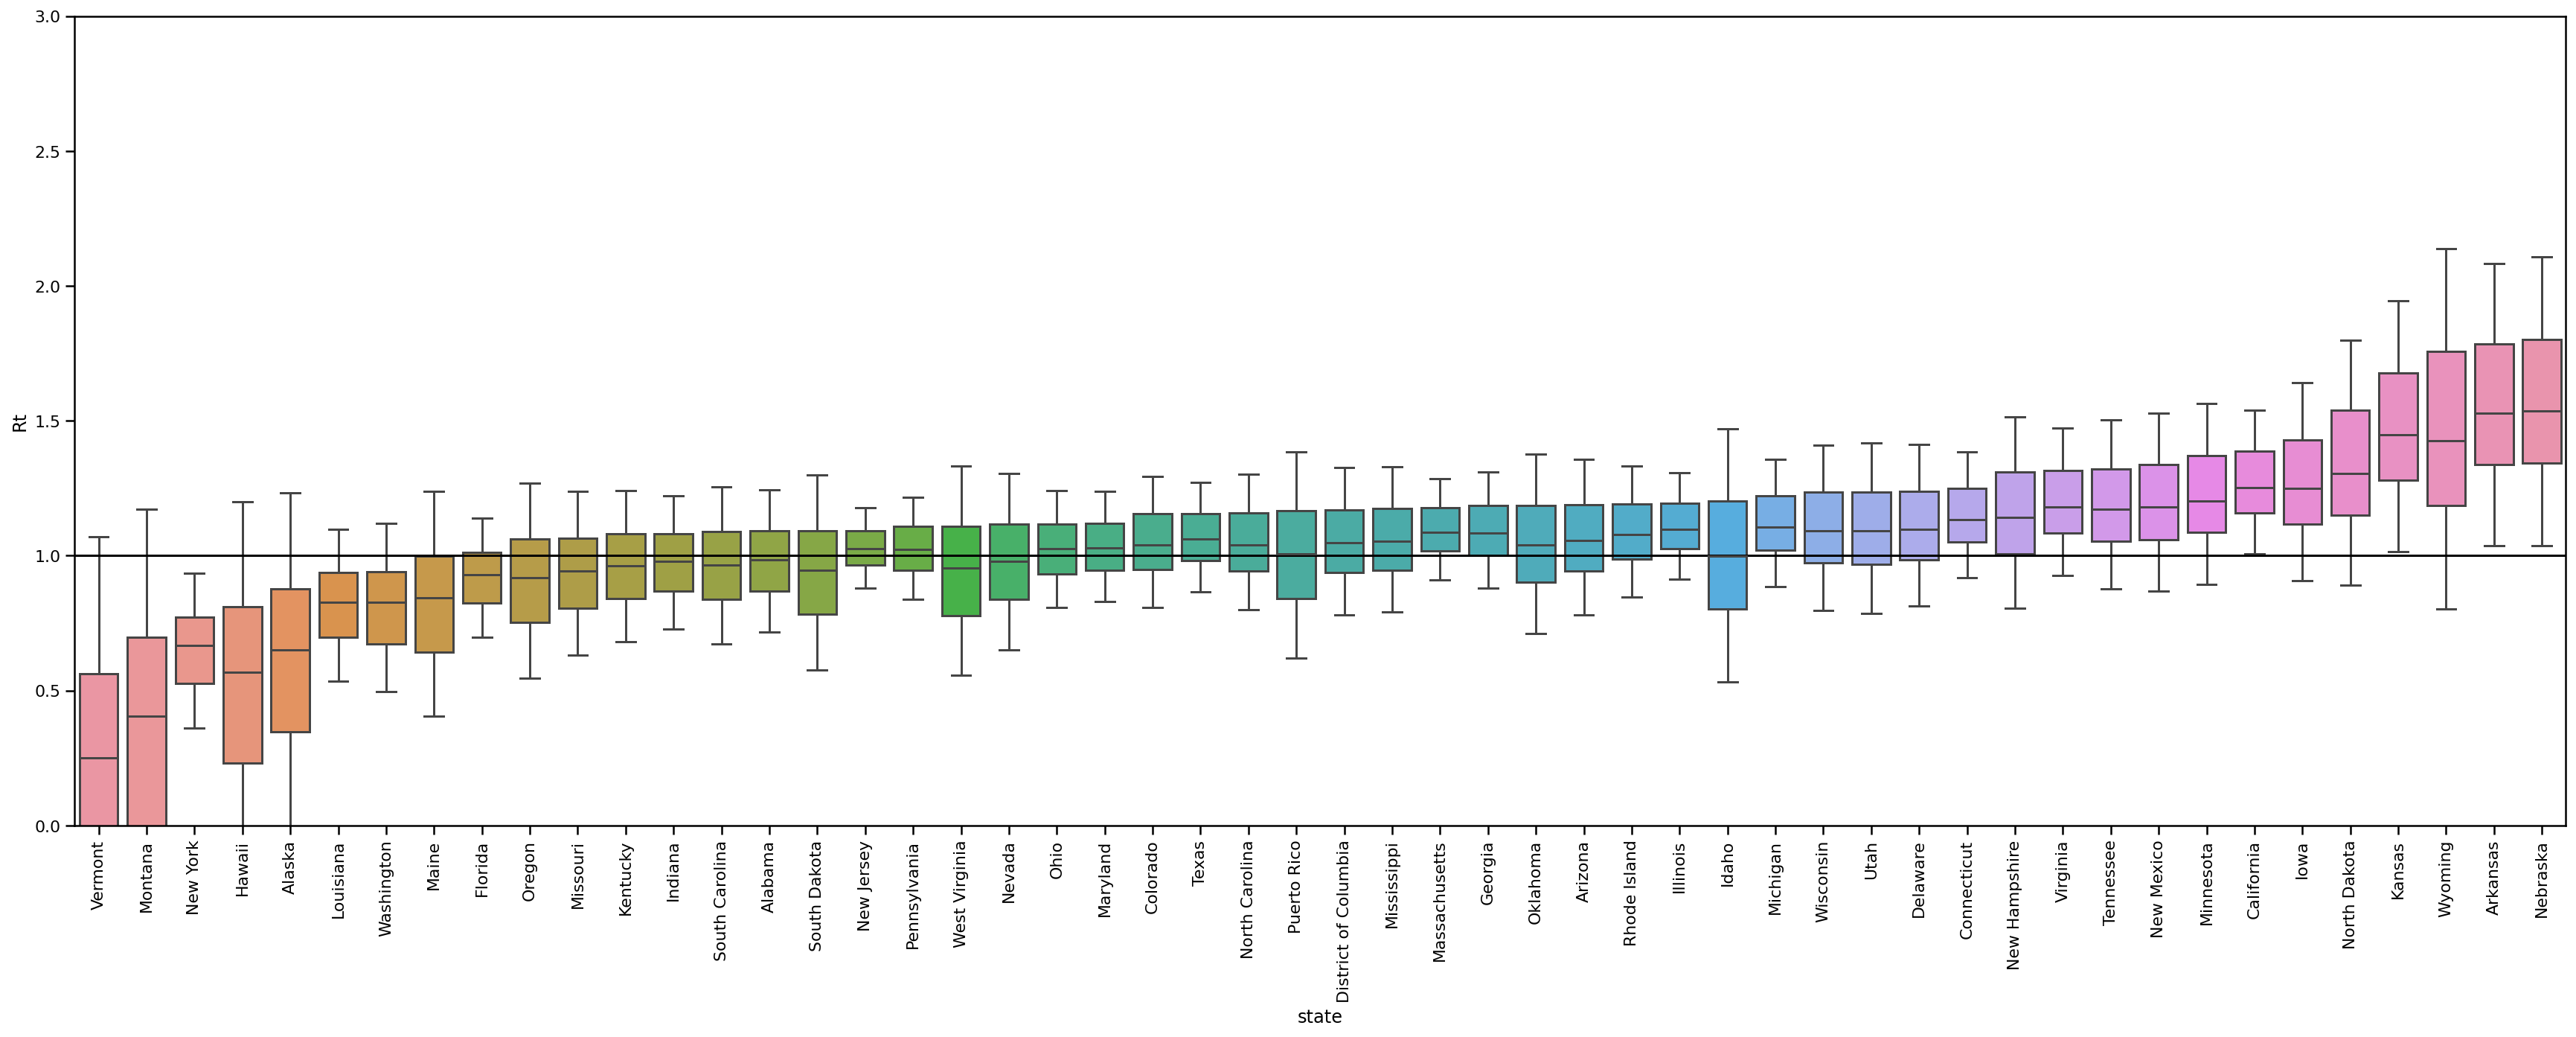

In [36]:
figure(figsize=(30, 10))
sns.boxplot(x='state', y='Rt', data=df, order=state_order, fliersize=0, whis=1.35/2)
axhline(1, color='k')
axis(ymin=0, ymax=3)
xticks(rotation=90)